In [ ]:
!pip install gym pandas numpy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install "stable-baselines3[extra]>=2.0.0a4"


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gym
import numpy as np
import pandas as pd
from gym import spaces


In [ ]:
class TradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, data, initial_balance=10000, leverage=1, max_drawdown=0.2, spread=2, allowed_weekend=False, base_currency='USD', max_lot_size=1.0, window=10, **kwargs):
        super(TradingEnv, self).__init__()

        self.data = data
        self.initial_balance = initial_balance
        self.leverage = leverage
        self.max_drawdown = max_drawdown
        self.spread = spread / 10000  # Convertir pips a unidades
        self.allowed_weekend = allowed_weekend
        self.base_currency = base_currency
        self.max_lot_size = max_lot_size
        self.window = window
        self.current_step = window
        self.lowest_balance = initial_balance

        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(2,), dtype=np.float32)  # Espacio de acciones continuas con dos dimensiones
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(window, 7))  # Ajustar la dimensión para incluir la información de varios períodos

    def reset(self):
        self.current_step = self.window
        self.balance = self.initial_balance
        self.units_held = 0
        self.total_units_sold = 0
        self.total_units_bought = 0
        self.net_worth = self.initial_balance
        self.lowest_balance = self.initial_balance
        self.stop_loss = None

        return self._get_observation()

    def _get_observation(self):
        window_data = self.data.iloc[self.current_step - self.window:self.current_step]
        day_of_week = window_data.index.dayofweek.to_numpy()
        obs = np.column_stack([
            window_data['open'].to_numpy(),
            window_data['high'].to_numpy(),
            window_data['low'].to_numpy(),
            window_data['close'].to_numpy(),
            window_data['volume'].to_numpy(),
            np.full(self.window, self.balance),
            day_of_week
        ])

        return obs

    def step(self, action):
        current_price = self.data.iloc[self.current_step]['Close']
        day_of_week = self.data.iloc[self.current_step].index.day_of_week
        self.current_step += 1
        prev_net_worth = self.net_worth
        done = False

        lot_size = action[0] * self.max_lot_size
        stop_loss_multiplier = action[1]  # Asumimos que stop_loss_multiplier está en el rango [-1, 1]

        if not self.allowed_weekend and day_of_week == 4:  # Si no se permiten operaciones durante el fin de semana y es viernes
            lot_size = -1.0  # Forzar la venta de todas las posiciones

        if lot_size > 0:  # Buy
            units_to_buy = int((self.balance * self.leverage * lot_size) // ((current_price + self.spread) * 1000))
            self.balance -= units_to_buy * (current_price + self.spread) * 1000
            self.units_held += units_to_buy
            self.total_units_bought += units_to_buy
            self.stop_loss = current_price * (1 - stop_loss_multiplier)  # Establecer el stop-loss

        elif lot_size < 0:  # Sell
            units_to_sell = int(-lot_size * self.units_held)
            self.balance += units_to_sell * (current_price - self.spread) * 1000
            self.units_held -= units_to_sell
            self.total_units_sold += units_to_sell

        self.net_worth = self.balance + self.units_held * current_price * 1000
        self.lowest_balance = min(self.lowest_balance, self.balance)

        if self.stop_loss is not None and current_price <= self.stop_loss:  # Si se alcanza el stop-loss
            self.balance += self.units_held * (self.stop_loss - self.spread) * 1000
            self.units_held = 0

        if self.net_worth <= self.initial_balance * (1 - self.max_drawdown):
            done = True

        done |= self.current_step >= len(self.data) - 1
        reward = self.net_worth - prev_net_worth

        return self._get_observation(), reward, done, {}

    def render(self, mode='human'):
        print(f"Step: {self.current_step}, Net Worth: {self.net_worth}, Balance: {self.balance}, Units Held: {self.units_held}, Stop Loss: {self.stop_loss}")

    def close(self):
        pass
            

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class TradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, data, initial_balance=10000, leverage=1, max_drawdown=0.2, spread=2, allowed_weekend=False, base_currency='USD', max_lot_size=1.0, window=10, **kwargs):
        super(TradingEnv, self).__init__()

        self.data = data
        self.initial_balance = initial_balance
        self.leverage = leverage
        self.max_drawdown = max_drawdown
        self.spread = spread / 10000  # Convertir pips a unidades
        self.allowed_weekend = allowed_weekend
        self.base_currency = base_currency
        self.max_lot_size = max_lot_size
        self.window = window
        self.current_step = window
        self.lowest_balance = initial_balance

        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(2,), dtype=np.float32)  # Espacio de acciones continuas con dos dimensiones
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(window, 7))  # Ajustar la dimensión para incluir la información de varios períodos

    def reset(self):
        self.current_step = self.window
        self.balance = self.initial_balance
        self.units_held = 0
        self.total_units_sold = 0
        self.total_units_bought = 0
        self.net_worth = self.initial_balance
        self.lowest_balance = self.initial_balance
        self.stop_loss = None

        return self._get_observation()

    def _get_observation(self):
        window_data = self.data.iloc[self.current_step - self.window:self.current_step]
        day_of_week = window_data.index.dayofweek.to_numpy()
        obs = np.column_stack([
            window_data['open'].to_numpy(),
            window_data['high'].to_numpy(),
            window_data['low'].to_numpy(),
            window_data['close'].to_numpy(),
            window_data['volume'].to_numpy(),
            np.full(self.window, self.balance),
            day_of_week
        ])

        return obs

    def step(self, action):
        current_price = self.data.iloc[self.current_step]['Close']
        day_of_week = self.data.iloc[self.current_step].index.day_of_week
        self.current_step += 1
        prev_net_worth = self.net_worth
        done = False

        lot_size = action[0] * self.max_lot_size
        stop_loss_multiplier = action[1]  # Asumimos que stop_loss_multiplier está en el rango [-1, 1]

        if not self.allowed_weekend and day_of_week == 4:  # Si no se permiten operaciones durante el fin de semana y es viernes
            lot_size = -1.0  # Forzar la venta de todas las posiciones

        if lot_size > 0:  # Buy
            units_to_buy = int((self.balance * self.leverage * lot_size) // ((current_price + self.spread) * 1000))
            self.balance -= units_to_buy * (current_price + self.spread) * 1000
            self.units_held += units_to_buy
            self.total_units_bought += units_to_buy
            self.stop_loss = current_price * (1 - stop_loss_multiplier)  # Establecer el stop-loss

        elif lot_size < 0:  # Sell
            units_to_sell = int(-lot_size * self.units_held)
            self.balance += units_to_sell * (current_price - self.spread) * 1000
            self.units_held -= units_to_sell
            self.total_units_sold += units_to_sell

        self.net_worth = self.balance + self.units_held * current_price * 1000
        self.lowest_balance = min(self.lowest_balance, self.balance)

        if self.stop_loss is not None and current_price <= self.stop_loss:  # Si se alcanza el stop-loss
            self.balance += self.units_held * (self.stop_loss - self.spread) * 1000
            self.units_held = 0

        if self.net_worth <= self.initial_balance * (1 - self.max_drawdown):
            done = True

        done |= self.current_step >= len(self.data) - 1
        reward = self.net_worth - prev_net_worth

        return self._get_observation(), reward, done, {}

    def render(self, mode='human'):
        print(f"Step: {self.current_step}, Net Worth: {self.net_worth}, Balance: {self.balance}, Units Held: {self.units_held}, Stop Loss: {self.stop_loss}")

    def close(self):
        pass
            

In [ ]:
from stable_baselines3 import A2C

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/forex/EURUSD_ForexTrading_4hrs_05.05.2003_to_16.10.2021.csv",  index_col='Gmt time')
df.index = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S.%f', utc=True)
df.columns = df.columns.str.capitalize()





/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import sys
sys.path.append('/content/')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

from gym.envs.registration import register

register(
    id='TradingEnv-v2',
    entry_point='tradingEnv:TradingEnv',  # Reemplaza 'trading_env' con el nombre del archivo trading_env.py sin la extensión '.py'
)

In [ ]:
print(df.head())
print(df.index.dayofweek)
print(df.index[6].dayofweek)
df = df.dropna()


In [ ]:
train_data = df.iloc[:int(len(df)*0.8)]
test_data = df.iloc[int(len(df)*0.8):]

In [ ]:
from stable_baselines3 import PPO

env = gym.make('TradingEnv-v2', data=train_data, window=10, initial_balance=10000, max_drawdown=0.2)

# Crear un modelo de aprendizaje por refuerzo A2C
model = PPO('MlpPolicy', env, verbose=1)

# Entrenar el modelo durante 10,000 pasos
model.learn(total_timesteps=100000,progress_bar=True)

# Guardar el modelo entrenado
model.save("my_trading_model")

Output()

/usr/local/lib/python3.9/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core 
environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the 
environment with new step API. 
  logger.deprecation(

/usr/local/lib/python3.9/dist-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by
the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(

/usr/local/lib/python3.9/dist-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by
the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")

/usr/local/lib/python3.9/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (10, 7)
  logger.warn(
/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/stable_bas

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 523  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 2.89e+03     |
|    ep_rew_mean          | -2e+03       |
| time/                   |              |
|    fps                  | 398          |
|    iterations           | 2            |
|    time_elapsed         | 10           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0072580064 |
|    clip_fraction        | 0.0875       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | -1.8e-05     |
|    learning_rate        | 0.0003       |
|    los

Total Trades: 5690
Winning Trades: 2867
Losing Trades: 2823
Win Rate: 0.5038664323374341
Final Balance: 1358.2100000000064
Max Drawdown: -99.99%


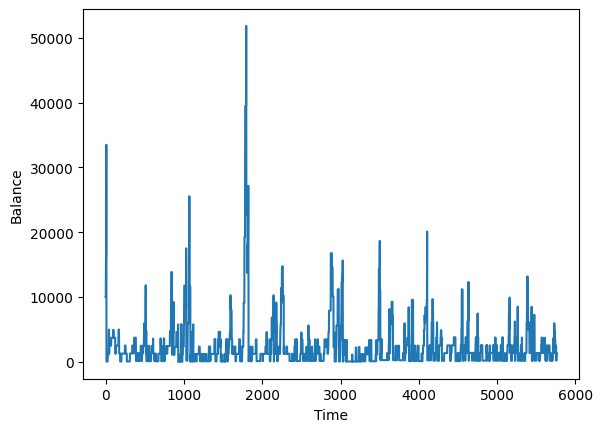

In [ ]:
test_env = gym.make('TradingEnv-v2', data=test_data, window=10, initial_balance=10000, max_drawdown=0.2)
obs = test_env.reset()
done = False
while not done:
    action, _states = model.predict(obs)
    obs, reward, done, info = test_env.step(action)

test_env = gym.make('TradingEnv-v2', data=test_data, window=10, initial_balance=10000, max_drawdown=0.2)
obs = test_env.reset()
done = False
balance = []
net_worth = []
units_held = []
units_bought = []
units_sold = []
winning_trades = 0
losing_trades = 0
while not done:
    action, _states = model.predict(obs)
    obs, reward, done, info = test_env.step(action)
    balance.append(test_env.balance)
    net_worth.append(test_env.net_worth)
    units_held.append(test_env.units_held)
    units_bought.append(test_env.total_units_bought)
    units_sold.append(test_env.total_units_sold)
    if reward > 0:
        winning_trades += 1
    elif reward < 0:
        losing_trades += 1

# Generar un informe detallado del backtest
total_trades = winning_trades + losing_trades
win_rate = winning_trades / total_trades
print(f"Total Trades: {total_trades}")
print(f"Winning Trades: {winning_trades}")
print(f"Losing Trades: {losing_trades}")
print(f"Win Rate: {win_rate}")
print(f"Final Balance: {balance[-1]}")
print(f"Max Drawdown: {min(balance) / max(balance) - 1:.2%}")

# Generar un plot del balance durante el backtest
plt.plot(balance)
plt.xlabel("Time")
plt.ylabel("Balance")
plt.show()